# Unit 5 - Financial Planning

In [43]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
import matplotlib.pyplot as plt

In [81]:
# Load .env enviroment variables, allow user to define path or use .env in current dir
env_path = Path('Path/goes/here')
if os.path.exists(env_path):
    print (f'Using .env file in path {env_path}')
    load_dotenv(dotenv_path=env_path)
else:
    print ('Using local .env file')
    load_dotenv()

Using local .env file


In [45]:
# set constants for API keys, check type.
ALPACA_API_KEY = os.getenv('ALPACA_API_KEY')
ALPACA_SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')
type(ALPACA_API_KEY), type(ALPACA_SECRET_KEY)

(str, str)

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [46]:
# Set current amount of crypto assets
crypto_holdings = {
    'BTC':1.2,
    'ETH':5.3
}

In [47]:
# Crypto API URLs (maybe convert to AUD later on?)
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [48]:
# Function to get price 
def get_price(url):
    '''
    Takes alternative API url pointing to a ticker. Returns the price of the cryptocurrency in USD.

    json object structure: data (dict) > id (dict) > quotes (dict) > currency (dict) > price (key)

    url (str) = URL pointing to cryptocurrency ticker
    
    '''
    # access API and store as json
    response = requests.get(url).json()

    # get price, assuming the unique id is always the first element in the 'data' object
    price = list(response['data'].values())[0]['quotes']['USD']['price']
    return price


In [49]:
# Fetch current BTC price
btc_price = get_price(btc_url)

# Fetch current ETH price
eth_price = get_price(eth_url)

# Compute current value of my crypto
crypto_value = {
    'BTC_value' : crypto_holdings['BTC']*btc_price,
    'ETH_value' : crypto_holdings['ETH']*eth_price
}
# Print current crypto wallet balance
print(f"The current value of your {crypto_holdings['BTC']} BTC is ${crypto_value['BTC_value']:0.2f} USD")
print(f"The current value of your {crypto_holdings['ETH']} ETH is ${crypto_value['ETH_value']:0.2f} USD")

The current value of your 1.2 BTC is $49008.00 USD
The current value of your 5.3 ETH is $15070.44 USD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [50]:
# Set current amount of shares
share_folio = {
    'AGG' : 200,
    'SPY' : 50
}

In [51]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2")

In [52]:
# create function for api call, due to the get_barset function being depreciated, get_bars was used.
# this function returns data in a different form so additional data wrangling was nessecary.
def ticker_data (ticker, start = 1500):
    '''
    Uses the alpaca.get_bars function to obtain historical data about a stock ticker,

    slices API response and returns a Dataframe with datetime index.

    ticker (str) = stock ticker of interest

    start (int) =  neumerical value describing amount of historical data to collect (weekends/public holidays included).
    '''

    # Use yesterday because open markets can cause the api to return an error when requesting daily data.
    # use time local to the origin of the data (NY timezone).
    end_date = (pd.Timestamp("today", tz="America/New_York") - pd.DateOffset(1)).isoformat()

    # Set start date (default = 1501, approx 1000 trading days)
    start_date = (pd.Timestamp("today", tz="America/New_York") - pd.DateOffset(1+start)).isoformat()

    # Call API, pass in ticker argument, set timeframe to Day and set time period.
    data = alpaca.get_bars(
        ticker,
        tradeapi.TimeFrame.Day,
        start = start_date,
        end = end_date,
        adjustment='raw'
    ).df

    # slice columns
    data = data.drop(['trade_count', 'vwap', 'volume'], axis='columns')

    return data

In [53]:
# Because the later section uses historical data, get and store 5 years of data (assuming exactly 365 days/year)
five_years = 365*5

# call function for each ticker
spy = ticker_data('SPY', five_years)
agg = ticker_data('AGG', five_years)

# concatenate the ticker data and set keys for multi-indexing along columns
stock_data = pd.concat([spy, agg], keys=['SPY', 'AGG'], axis='columns', join='inner')

# drop na, sort data.
stocks = stock_data.dropna().sort_index(ascending=True)

# Preview DataFrame
stock_data


SPY                              AGG           \
                              open    high     low    close    open     high   
timestamp                                                                      
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.760  107.93  108.270   
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250  108.44  108.540   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940  108.44  108.510   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880  108.35  108.510   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575  108.65  108.710   
...                            ...     ...     ...      ...     ...      ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000  107.78  107.816   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170  107.83  107.920   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620  107.63  107.730   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070  107.87  108.060   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520  107.95  108.140   

                                             
                                low   close  
timestamp                                    
2017-03-21 04:00:00+00:00  107.9300  108.27  
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36  
2017-03-27 04:00:00+00:00  108.5345  108.62  
...                             ...     ...  
2022-03-14 04:00:00+00:00  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.0032  107.68  
2022-03-17 04:00:00+00:00  107.7300  107.86  
2022-03-18 04:00:00+00:00  107.9203  108.10  

[1259 rows x 8 columns]

In [54]:
# access the last element of the data for portfolio calaulcations
agg_close = stocks['AGG', 'close'][-1]
spy_close = stocks['SPY', 'close'][-1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close}")
print(f"Current SPY closing price: ${spy_close}")

Current AGG closing price: $108.1
Current SPY closing price: $444.52


In [55]:
# Compute the current value of shares
share_value = {
    'AGG_value' : share_folio['AGG']*agg_close,
    'SPY_value' : share_folio['SPY']*spy_close
}

# Print current value of shares
print(f"The current value of your {share_folio['SPY']} SPY shares is ${share_value['SPY_value']:0.2f}")
print(f"The current value of your {share_folio['AGG']} AGG shares is ${share_value['AGG_value']:0.2f}")

The current value of your 50 SPY shares is $22226.00
The current value of your 200 AGG shares is $21620.00


### Savings Health Analysis

In [56]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = sum(crypto_value.values())
shares = sum(share_value.values())

# Create savings DataFrame, pass in data, transpose and rename column.
df_savings = pd.DataFrame({'crypto':[crypto], 'shares':[shares]}).T.rename(columns={0:'amount'})

# Display savings DataFrame
df_savings

,amount
crypto,64078.444
shares,43846.000


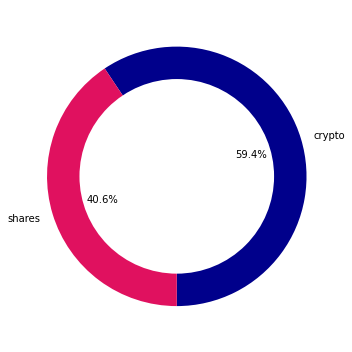

In [57]:
# Plot savings pie chart (maybe use this section to experiment, snippets of code used from link below)
# https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

# inputs
labels=df_savings.index.tolist()
values=df_savings['amount'].tolist() 
fig1, ax1 = plt.subplots(figsize=(5,5))
colors = ['#00008B','#E0115F']

# pie chart
ax1.pie(values, colors=colors, labels=labels, autopct='%1.1f%%', startangle = 270)

# draw inner white circle
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# format and show plot
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [58]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()

# Validate saving health
if savings > emergency_fund:
    print (f'Congratulations, your total savings of {savings:0.2f} should cover you in an emergency.')
elif savings == emergency_fund:
    print (f'Congratulations, you have reached your goal of {savings:0.2f} for an emergency fund!')
else:
    print (f'Your emergency fund is {(emergency_fund-savings):0.2f} away from your goal of {emergency_fund:0.2f}. Keep going!')

Congratulations, your total savings of 107924.44 should cover you in an emergency.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [59]:
#confirm the data is still in the form that is needed for MC simulations
stock_data

SPY                              AGG           \
                              open    high     low    close    open     high   
timestamp                                                                      
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.760  107.93  108.270   
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250  108.44  108.540   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940  108.44  108.510   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880  108.35  108.510   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575  108.65  108.710   
...                            ...     ...     ...      ...     ...      ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000  107.78  107.816   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170  107.83  107.920   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620  107.63  107.730   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070  107.87  108.060   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520  107.95  108.140   

                                             
                                low   close  
timestamp                                    
2017-03-21 04:00:00+00:00  107.9300  108.27  
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36  
2017-03-27 04:00:00+00:00  108.5345  108.62  
...                             ...     ...  
2022-03-14 04:00:00+00:00  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.0032  107.68  
2022-03-17 04:00:00+00:00  107.7300  107.86  
2022-03-18 04:00:00+00:00  107.9203  108.10  

[1259 rows x 8 columns]

In [60]:
# Set weights for the portfolio (ensure that the order of the dict is the same as the order of the dataset)
weights = {
    'SPY':0.6,
    'AGG':0.4
}

# Configure a Monte Carlo simulation to forecast 30 years cumulative returns
# initilize monte carlo simulation. Forecasted trading days is 30 years (252 * 30)
mc_sim = MCSimulation(
    portfolio_data = stock_data,
    weights=list(weights.values()),
    num_simulation=500,
    num_trading_days=252*30
    )

In [61]:
# Print the simulation input data, verify that MCForecastTools has calculated daily return
mc_sim.portfolio_data

SPY                                        \
                              open    high     low    close daily_return   
timestamp                                                                  
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.760          NaN   
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250     0.002096   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940    -0.001323   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880    -0.000256   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575    -0.001304   
...                            ...     ...     ...      ...          ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000    -0.007308   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170     0.021990   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620     0.022174   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070     0.012511   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520     0.007822   

                              AGG                                          
                             open     high       low   close daily_return  
timestamp                                                                  
2017-03-21 04:00:00+00:00  107.93  108.270  107.9300  108.27          NaN  
2017-03-22 04:00:00+00:00  108.44  108.540  108.3600  108.42     0.001385  
2017-03-23 04:00:00+00:00  108.44  108.510  108.2635  108.45     0.000277  
2017-03-24 04:00:00+00:00  108.35  108.510  108.3100  108.36    -0.000830  
2017-03-27 04:00:00+00:00  108.65  108.710  108.5345  108.62     0.002399  
...                           ...      ...       ...     ...          ...  
2022-03-14 04:00:00+00:00  107.78  107.816  107.3600  107.36    -0.009685  
2022-03-15 04:00:00+00:00  107.83  107.920  107.4300  107.60     0.002235  
2022-03-16 04:00:00+00:00  107.63  107.730  107.0032  107.68     0.000743  
2022-03-17 04:00:00+00:00  107.87  108.060  107.7300  107.86     0.001672  
2022-03-18 04:00:00+00:00  107.95  108.140  107.9203  108.10     0.002225  

[1259 rows x 10 columns]

In [62]:
# Run a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Financial-Monte-Carlo/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993215,1.001514,1.001302,0.997749,1.013035,1.000627,1.009538,1.005932,0.991948,0.986361,...,0.997556,0.998762,1.004837,1.015935,1.006872,1.016489,0.990274,1.001843,0.989796,1.009440
2,1.001393,0.989870,0.992711,1.006092,1.011014,1.012231,1.004195,1.012057,0.993315,0.995942,...,1.007092,1.003140,0.999797,1.026498,1.000668,1.012899,0.989902,1.002717,0.990478,1.003728
3,0.996900,0.997502,0.985176,1.011037,1.023978,1.012270,1.003246,1.008733,0.987992,0.989641,...,0.997692,0.989491,0.996079,1.025163,1.003796,0.994808,0.988547,1.009882,0.991562,0.998019
4,1.002828,0.993601,0.971695,1.008836,1.017031,1.028424,1.006342,1.003053,0.993580,0.994100,...,0.984995,1.010420,0.994350,1.033542,1.003202,0.999154,0.979191,1.012155,1.000070,1.017081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,9.221751,12.848885,7.431657,6.964791,19.533720,14.191152,7.008964,7.567663,5.399183,8.544106,...,2.613189,8.929411,10.491296,11.804499,15.395954,13.311267,7.420908,14.066878,3.958906,12.387580
7557,9.215789,12.874726,7.460807,6.987747,19.573317,14.075639,7.012389,7.546142,5.477741,8.484308,...,2.602634,8.959856,10.513295,11.756237,15.283503,13.306677,7.340332,14.249100,3.944674,12.457144
7558,9.260047,12.888005,7.430804,6.949509,19.620114,14.195225,6.973651,7.577157,5.492863,8.461273,...,2.604398,8.973009,10.416321,11.672765,15.272998,13.400126,7.361577,14.414832,3.977290,12.574581
7559,9.204630,12.875406,7.356345,6.925158,19.566969,14.137634,7.006661,7.525250,5.441288,8.418077,...,2.611287,8.869586,10.489183,11.929569,15.382240,13.470531,7.343178,14.320296,3.960504,12.690649


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

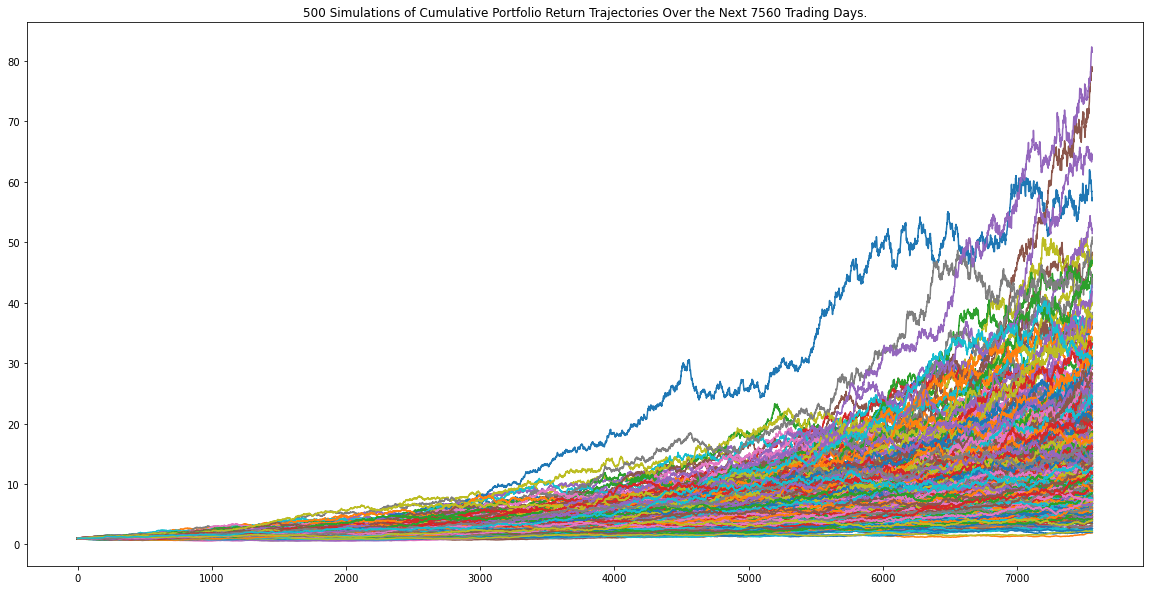

In [63]:
# Plot simulation outcomes
mc_sim.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

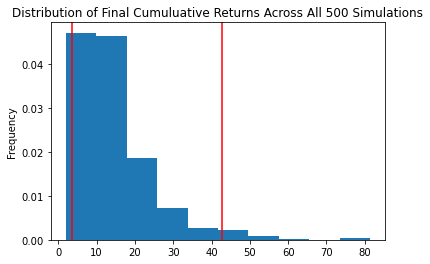

In [64]:
# Plot probability distribution and confidence intervals
mc_sim.plot_distribution()

### Retirement Analysis

In [65]:
# Fetch summary statistics from the Monte Carlo simulation results
summary = mc_sim.summarize_cumulative_return()

# Print summary statistics
summary

count           500.000000
mean             14.549426
std              10.262206
min               1.915194
25%               7.719566
50%              12.101761
75%              18.023648
max              81.413615
95% CI Lower      3.418060
95% CI Upper     42.798591
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [66]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of $20,000 investment.
lower = initial_investment*summary['95% CI Lower']
upper = initial_investment*summary['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower:0.2f} and ${upper:0.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $68361.21 and $855971.81


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [67]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
lower = initial_investment*summary['95% CI Lower']
upper = initial_investment*summary['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower:0.2f} and ${upper:0.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $102541.81 and $1283957.72


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [68]:
# configure a more agressive portfolio for a 5 year strategy
weights_5 = {
    'SPY':0.8,
    'AGG':0.2
}

In [69]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5 = MCSimulation(portfolio_data = stock_data, weights=list(weights_5.values()), num_simulation=500, num_trading_days=252*5)

In [70]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Financial-Monte-Carlo/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002685,1.012551,0.998280,0.985062,1.003408,0.987804,1.007156,1.017288,1.018666,0.996769,...,1.008769,1.001465,0.999205,0.990887,0.991601,0.995160,0.995280,0.995028,1.000587,1.008732
2,0.987159,0.999883,1.019524,0.980147,1.002213,0.979988,1.001491,1.025935,1.020649,0.997060,...,1.010814,0.988458,1.006307,0.992206,0.990664,1.002896,0.975845,0.988471,0.989409,1.012446
3,0.969965,1.002827,1.031161,0.984196,1.018343,0.978895,1.020025,1.032402,1.026065,1.018911,...,0.996789,0.988193,0.986738,0.989900,0.997859,1.003752,0.968889,1.007275,0.978103,1.018608
4,0.967110,1.016435,1.026735,0.977652,1.011323,0.967621,1.009136,1.022708,1.032940,1.023242,...,1.000408,0.990519,0.991913,0.982857,0.969938,1.000848,0.986190,1.006657,0.981517,1.018843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.778572,1.228212,1.411542,1.879158,1.237075,0.718537,1.739318,1.845331,1.297976,1.721154,...,1.392748,1.562514,2.037969,1.508863,2.268159,1.730674,1.777162,2.663751,1.955627,1.103161
1257,1.767857,1.215069,1.408614,1.885613,1.227815,0.729586,1.752553,1.855721,1.300454,1.697213,...,1.392530,1.555568,2.027842,1.510220,2.296621,1.739792,1.791832,2.710276,1.977358,1.104812
1258,1.765007,1.226630,1.402661,1.871216,1.225986,0.719860,1.743990,1.852646,1.296518,1.717323,...,1.397729,1.570639,2.031778,1.525319,2.307009,1.721215,1.790613,2.749725,1.948551,1.107378
1259,1.759612,1.223171,1.402494,1.870520,1.229155,0.718908,1.748934,1.873912,1.319260,1.718513,...,1.403757,1.573461,2.015384,1.525723,2.284503,1.736334,1.785339,2.714228,1.972056,1.088843


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

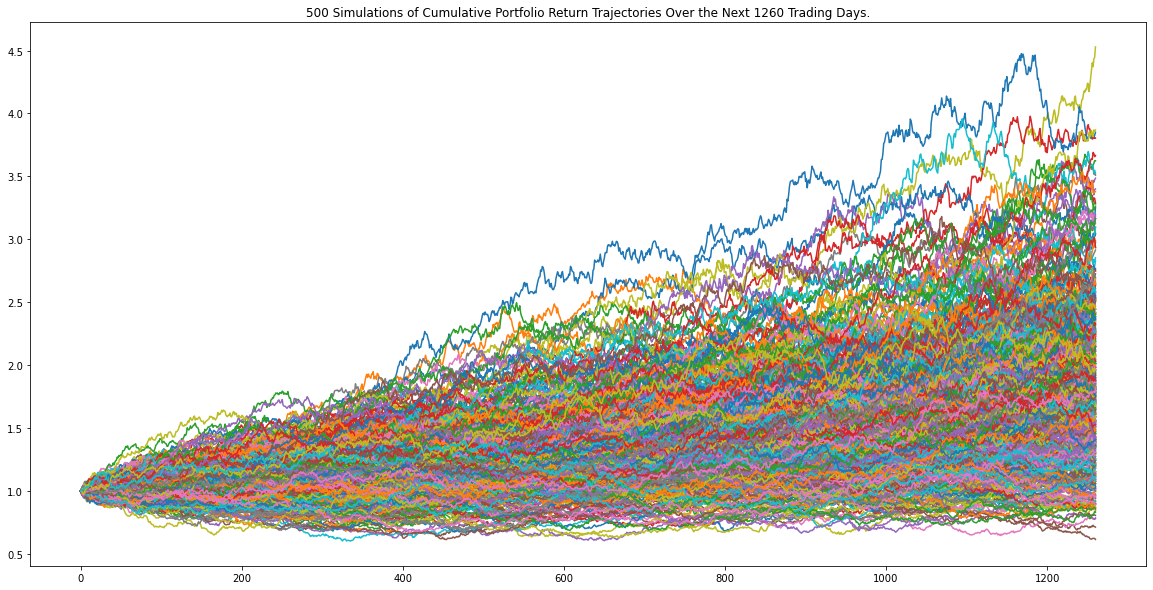

In [71]:
# Plot simulation outcomes
mc_sim_5.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

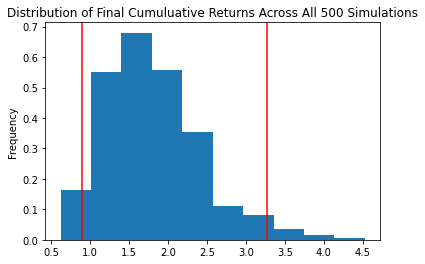

In [72]:
# Plot probability distribution and confidence intervals
mc_sim_5.plot_distribution()

In [73]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_5 = mc_sim_5.summarize_cumulative_return()

# Print summary statistics
summary_5

count           500.000000
mean              1.803035
std               0.609226
min               0.616842
25%               1.373324
50%               1.730441
75%               2.149630
max               4.528611
95% CI Lower      0.893672
95% CI Upper      3.272700
Name: 1260, dtype: float64

In [74]:
# Set initial investment
initial_investment_5 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
lower_5 = initial_investment_5*summary_5['95% CI Lower']
upper_5 = initial_investment_5*summary_5['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${lower_5:0.2f} and ${upper_5:0.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 5 years will end within in the range of $53620.32 and $196361.97


### Ten Years Retirement Option

In [75]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns using original 60/40 weigths
mc_sim_10 = MCSimulation(portfolio_data = stock_data, weights=list(weights.values()), num_simulation=500, num_trading_days=252*10)

In [76]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_10.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Financial-Monte-Carlo/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998758,1.009010,1.001893,0.994451,0.991570,1.010067,0.989606,0.996129,0.990575,1.012354,...,1.003162,0.998376,0.991552,1.006160,1.000376,1.007328,0.994671,1.011306,0.994707,1.004308
2,0.996372,1.007432,0.992442,0.986803,0.989834,1.025265,0.981052,1.002813,0.982995,1.022864,...,0.990351,0.995937,0.998060,1.012472,1.000629,1.000757,0.995303,1.019643,0.978400,0.998823
3,0.998738,0.999687,0.988899,0.996082,0.982806,1.026520,0.982205,1.012551,0.988880,1.023977,...,0.990503,0.994295,0.989812,1.005477,1.011446,0.997998,1.002275,1.023967,0.975762,0.988093
4,0.989621,0.993330,0.987737,0.994176,0.983729,1.029349,0.968999,1.001142,0.993200,1.031713,...,0.982107,0.999555,0.993780,1.006400,1.010731,0.997072,1.011885,1.028362,0.971952,0.988059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.132177,2.205186,2.146163,2.082438,1.582893,2.757669,2.134136,3.578661,2.977996,2.263820,...,2.446327,4.415939,1.224019,2.468907,2.768923,2.200058,1.747752,4.095484,3.545696,2.065080
2517,2.162688,2.194543,2.143579,2.088023,1.571835,2.786722,2.150196,3.598091,3.003019,2.260012,...,2.437798,4.415215,1.220305,2.505753,2.731952,2.176923,1.717158,4.083717,3.522850,2.064754
2518,2.163995,2.189664,2.154697,2.071362,1.558611,2.802498,2.177420,3.609004,2.985707,2.248106,...,2.456479,4.420963,1.203697,2.531628,2.728618,2.187657,1.717876,4.064255,3.476036,2.067899
2519,2.144139,2.171164,2.188704,2.084994,1.564569,2.795898,2.169824,3.660137,3.026158,2.256332,...,2.480496,4.421493,1.206808,2.524948,2.705282,2.201707,1.720967,4.039908,3.455887,2.057476


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

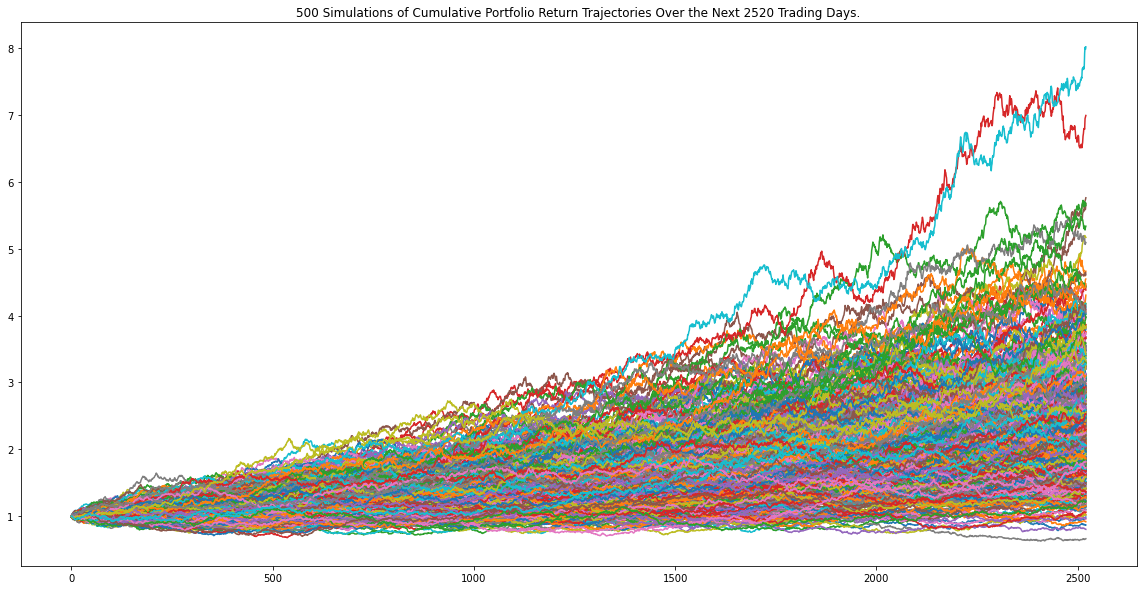

In [77]:
# Plot simulation outcomes
mc_sim_10.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

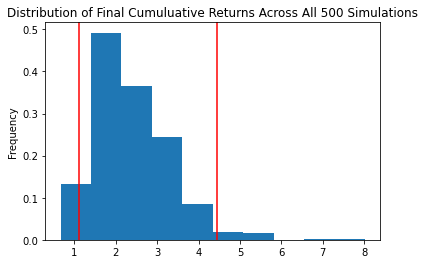

In [78]:
# Plot probability distribution and confidence intervals
mc_sim_10.plot_distribution()

In [79]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_10 = mc_sim_10.summarize_cumulative_return()

# Print summary statistics
summary_10

count           500.000000
mean              2.411595
std               0.918793
min               0.663223
25%               1.782872
50%               2.211665
75%               2.942178
max               8.019497
95% CI Lower      1.099873
95% CI Upper      4.437777
Name: 2520, dtype: float64

In [80]:
# Set initial investment
initial_investment_10 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
lower_10 = initial_investment_10*summary_10['95% CI Lower']
upper_10 = initial_investment_10*summary_10['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${lower_10:0.2f} and ${upper_10:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $65992.36 and $266266.63
